In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

#### Setup - Defines paths to our dataset

In [4]:
LEFT_IMG_DIR = "data_scene_flow/training/image_2"
RIGHT_IMG_DIR = "data_scene_flow/training/image_3"
CALIB_DIR = "data_scene_flow_calib/training/calib_cam_to_cam"

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'disparity'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'depth'), exist_ok=True)

In [5]:
print(f"KITTI Left Images: {LEFT_IMG_DIR}")
print(f"KITTI Right Images: {RIGHT_IMG_DIR}")
print(f"KITTI Calibration: {CALIB_DIR}")

KITTI Left Images: data_scene_flow/training/image_2
KITTI Right Images: data_scene_flow/training/image_3
KITTI Calibration: data_scene_flow_calib/training/calib_cam_to_cam


In [71]:
# Get list of image files (assuming they are sorted and correspond)
left_image_files = sorted(glob.glob(os.path.join(LEFT_IMG_DIR, '*_10.png')))
right_image_files = sorted(glob.glob(os.path.join(RIGHT_IMG_DIR, '*_10.png')))
calib_files = sorted(glob.glob(os.path.join(CALIB_DIR, '*.txt')))

print(f"Found {len(left_image_files)} left images, {len(right_image_files)} right images, {len(calib_files)} calibration files.")

Found 200 left images, 200 right images, 200 calibration files.


In [11]:
# Verify that counts match
assert len(left_image_files) == len(right_image_files) == 2 * len(calib_files), \
    "Mismatch in number of left images, right images, or calibration files."

In [12]:
# Let's pick one example image index to work with initially
example_idx = 0
print(f"\nProcessing example image pair (index {example_idx}):")
print(f"Left: {left_image_files[example_idx]}")
print(f"Right: {right_image_files[example_idx]}")
print(f"Calib: {calib_files[example_idx]}")


Processing example image pair (index 0):
Left: data_scene_flow/training/image_2/000000_10.png
Right: data_scene_flow/training/image_3/000000_10.png
Calib: data_scene_flow_calib/training/calib_cam_to_cam/000000.txt


#### Load and Parse KITTI Calibration

In [41]:
def read_calib_file(
    filepath,
    cam_left = "P_rect_02",
    cam_right = "P_rect_03"
):
    data = {}
    with open(filepath, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith(cam_left + ':') or line.startswith(cam_right + ':'):
                key, val = line.split(':', 1)
                data[key.strip()] = np.array([float(x) for x in val.strip().split()]).reshape(3, 4)

    P2 = data[cam_left]
    P3 = data[cam_right]

    # From P2 and P3, we can extract focal length (fx) and baseline (B)
    # For rectified images, fx = fy
    fx = P2[0, 0] # Focal length (pixels) from the left camera's rectrified projection matrix

    # Baseline calculation:
    # In KITTI's rectified projection matrices, P_rect_02[0, 3] (Tx_left_rect) is typically 0.
    # P_rect_03[0, 3] (Tx_right_rect) holds - fx * baseline.
    # So, baseline = -P_rect_03[0,3] / fx
    baseline = abs(P2[0, 3] - P3[0, 3]) / fx

    # Construct the Q matrix (reprojection matrix) for cv2.reprojectImageTo3D
    # This Q matrix transforms a 2D point (x, y, disarity) into a 3D point (X, Y, Z, 1)
    # using the formula: (X, Y, Z, 1)^T = Q*(x, y, disparity, 1)^T
    # Components of Q are derived from rectified camera parameters.
    # The standard Q matrix structure:
    # Q = [[1, 0, 0, -cx_left],
    #      [0, 1, 0, -cy_left],
    #      [0, 0, 0, fx],
    #      [0, 0, 1/Tx, -(cx_left - cx_right_rect) / Tx]]
    # Where Tx is baseline.
    # However, for KITTI's P_rect matrices which have P_rect_02[0, 3] = 0 and P_rect_03[0, 3] = -fx * baseline,
    # a common and effective Q matrix can be derived directly from P2 and P3:
    Q_matrix = np.zeros((4, 4), dtype=np.float64)
    Q_matrix[0, 0] = 1.0
    Q_matrix[1, 1] = 1.0
    Q_matrix[2, 3] = P2[0, 0] # fx_rect (focal lenght)
    Q_matrix[3, 2] = 1.0 / (P3[0,3] / P2[0,0]) # 1 / (-B) from (f*B)/disp where B is the baseline
                                           # P3[0,3] is -f*B, so P3[0,3]/P2[0,0] is -B
    Q_matrix[0, 3] = -P2[0, 2] # -cx_rect (principal point x for left camera)
    Q_matrix[1, 3] = -P2[1, 2] # -cy_rect (principal point y for left camera)

    return fx, baseline, Q_matrix, P2, P3
    

fx, baseline, Q_matrix, P2_mat, P3_mat = read_calib_file(calib_files[example_idx])

print("\n--- KITTI Calibration Parameters ---")
print(f"Focal Length (fx): {fx:.2f} pixels")
print(f"Baseline (B): {baseline:.4f} meters")
print("Reprojection Matrix (Q):\n", Q_matrix)
print("Left Rectified Projection Matrix (P_rect_00 / P2):\n", P2_mat)
print("Right Rectified Projection Matrix (P_rect_01 / P3):\n", P3_mat)


--- KITTI Calibration Parameters ---
Focal Length (fx): 721.54 pixels
Baseline (B): 0.5327 meters
Reprojection Matrix (Q):
 [[   1.            0.            0.         -609.5593    ]
 [   0.            1.            0.         -172.854     ]
 [   0.            0.            0.          721.5377    ]
 [   0.            0.           -2.12514366    0.        ]]
Left Rectified Projection Matrix (P_rect_00 / P2):
 [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
Right Rectified Projection Matrix (P_rect_01 / P3):
 [[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  2.199936e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.729905e-03]]


#### Load and Convert Images

In [42]:
# Load the example image pair
img_left_color = cv2.imread(left_image_files[example_idx])
img_right_color = cv2.imread(right_image_files[example_idx])

# Convert to grayscale for stereo matching
img_left_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
img_right_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

In [43]:
# --- Stereo Matching Parameters (Tune these!) ---
# These parameters are critical for the quality of your disparity map.
# Experiment with them!

# SGBM Parameters:
# minDisparity: Minimum possible disparity value. Usually 0.
# numDisparities: Maximum disparity minus minimum disparity. Must be divisible by 16.
# blockSize: Matched block size. It must be an odd number >=1. Typically 3, 5, 7, ...
# P1, P2: Parameters controlling the disparity smoothness.
#         P1 = 8 * num_channels * blockSize^2 (for 8-bit images)
#         P2 = 32 * num_channels * blockSize^2
# disp12MaxDiff: Maximum allowed difference (in integer disparity units) in the left-right check.
# uniquenessRatio: A margin in percentage by which the best (minimum) cost function value
#                  must "win" against the second best.
# speckleWindowSize: Maximum size of smooth disparity regions to consider their noise speckles.
#                    Set to 0 to disable speckle filtering.
# speckleRange: Maximum disparity variation within each connected component.
# preFilterCap: Truncates the pixels with too large or too small intensity differences.
# mode: (Optional) Can be STEREO_SGBM_MODE_SGBM, STEREO_SGBM_MODE_HH, STEREO_SGBM_MODE_SGBM_3WAY, etc.
#       SGBM_3WAY is often good.

# KITTI images are already rectified, so we don't need to remap them here.


--- Stereo Matching (SGBM) Parameters ---
Num Disparities: 96
Block Size: 10


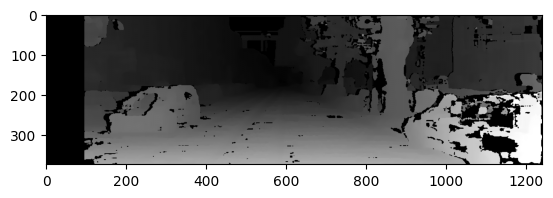

In [80]:
num_disparities = 16 * 6 # Example: 96 disparities (0 to 95)
block_size = 10 # Example: 10x10 block

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=8 * 3 * block_size**2,
    P2=32 * 3 * block_size**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY # Often good for real-world data
)

print(f"\n--- Stereo Matching (SGBM) Parameters ---")
print(f"Num Disparities: {num_disparities}")
print(f"Block Size: {block_size}")

# Compute disparity map
# Note: SGBM returns disparity values mutliplied by 16 for sub-pixel accuracy.
disparity = stereo.compute(img_left_gray, img_right_gray).astype(np.float32) / 16.0
plt.imshow(disparity, 'gray')
plt.show()

Raw Disparity Range: [0.00, 95.00]


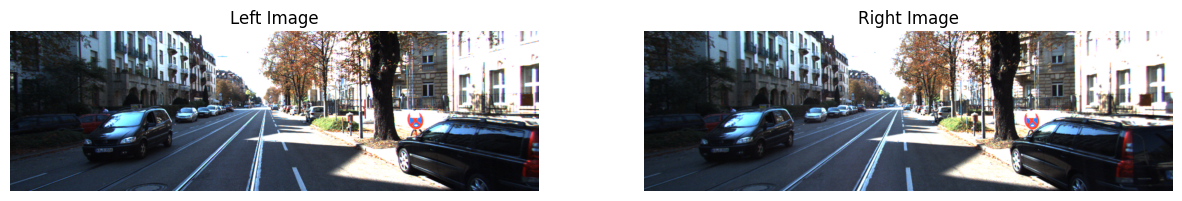

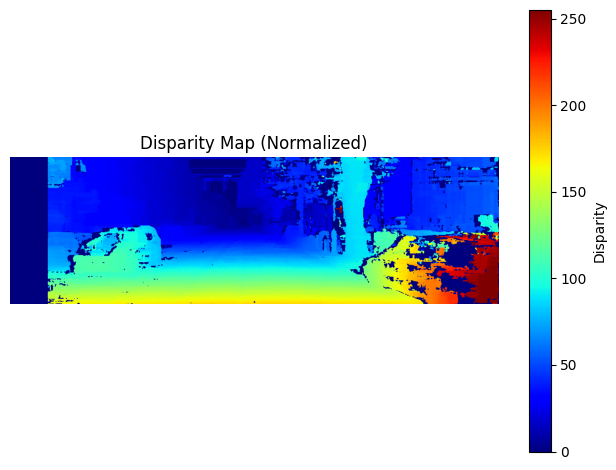

Disparity map saved to: output/disparity/disparity_000000_10.png


In [64]:
# --- Visualization of Disparity Map ---
# Normalize dispairyt map for display (0-255)
# Exclude invalid disparity values (usually -16 or similar from SGBM)
min_disp = disparity.min()
max_disp = disparity.max()
print(f"Raw Disparity Range: [{min_disp:.2f}, {max_disp:.2f}]")

# Handle potential inf/NaN values (though SGBM usually returns a specific invalid value)
disparity[disparity < 0] = 0 # Set invalid disparities (e.g., -1.0) to 0 or a specific placeholder

# Normalize for display
normalized_disparity = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB))
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_right_color, cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.axis('off')
plt.show()

plt.imshow(normalized_disparity, cmap='jet') # 'viridis', 'jet', 'plasma' are good colormaps
plt.title('Disparity Map (Normalized)')
plt.colorbar(label='Disparity')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the normalized disparity map
output_disparity_path = os.path.join(OUTPUT_DIR, 'disparity', f'disparity_{os.path.basename(left_image_files[example_idx])}')
cv2.imwrite(output_disparity_path, normalized_disparity)
print(f"Disparity map saved to: {output_disparity_path}")

#### Disparity to Depth Conversion

In [50]:
# --- Convert Disparity to Depth Map ---
# The formula is Z = f * B / D
# Where:
# Z = depth
# f = focal length (fx)
# B = baseline
# D = disparity

In [57]:
# For invalid disparities (often 0 or very small after filtering), depth will be infinite.
# We'll set these to a maximum depth or 0 for visualization.
depth_map = np.zeros_like(disparity, dtype=np.float32)
# Avoid division by zero
valid_disparity_mask = disparity > 0

# Apply the depth formula Z = f * B / D
# Note: For KITTI, their P2/P3 matrices are already in a form that if you apply
# reprojectImageTo3D with the Q matrix derived, it should give proper depth.
# The `f` and `B` from P2/P3 are already configured for depth in meters.
depth_map[valid_disparity_mask] = (fx * baseline) / disparity[valid_disparity_mask]

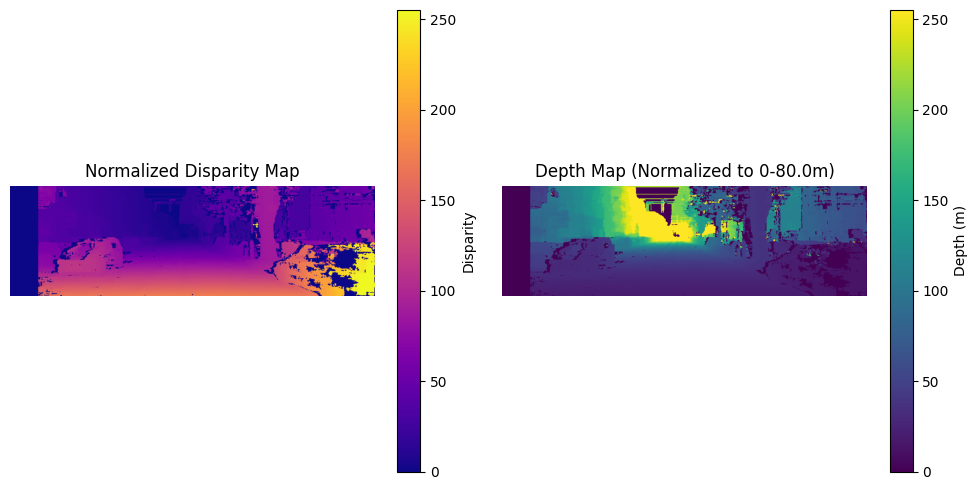

In [58]:
# --- Filter and Visualize Depth Map ---
# Define a reasonable max depth for visualization (e.g., objects beyond 80m are very far)
# KITTI is an outdoor dataset, so max_depth can be higher.
max_depth_vis = 80.0 # meters (adjust based on scene)
min_depth_vis = 0.5  # meters (filter out very close, potentially noisy depths)

# Clamp depths for better visualization and filter out noise/infinite values
depth_map[depth_map > max_depth_vis] = max_depth_vis
depth_map[depth_map < min_depth_vis] = 0 # Set very close/invalid to 0

# Normalize for display
# We want actual depth values, not just normalized ones.
# But for showing an image, we need to map the depth range to 0-255.
normalized_depth = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(normalized_disparity, cmap='plasma')
plt.title('Normalized Disparity Map')
plt.colorbar(label='Disparity')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_depth, cmap='viridis') # 'viridis' or 'magma' often good for depth
plt.title(f'Depth Map (Normalized to 0-{max_depth_vis:.1f}m)')
plt.colorbar(label='Depth (m)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [54]:
# Save the normalized depth map
output_depth_path = os.path.join(OUTPUT_DIR, 'depth', f'depth_{os.path.basename(left_image_files[example_idx])}')
cv2.imwrite(output_depth_path, normalized_depth)
print(f"Depth map saved to: {output_depth_path}")

# Optional: Display some actual depth values (e.g., at specific points)
# Pick a few points and print their depth
points_to_check = [(img_left_gray.shape[0]//2, img_left_gray.shape[1]//2), # Center
                   (img_left_gray.shape[0]//4, img_left_gray.shape[1]//4), # Top-left
                   (img_left_gray.shape[0]*3//4, img_left_gray.shape[1]*3//4)] # Bottom-right

print("\n--- Sample Depth Values ---")
for y, x in points_to_check:
    print(f"Depth at ({x}, {y}): {depth_map[y, x]:.2f} meters")

Depth map saved to: output/depth/depth_000000_10.png

--- Sample Depth Values ---
Depth at (621, 187): 80.00 meters
Depth at (310, 93): 45.56 meters
Depth at (931, 281): 7.38 meters
